## Import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.signal import convolve
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt
import cv2
from subprocess import check_output
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
import tensorflow 
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
#import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [2]:
def scheduler(epoch, lr):
...   if epoch < 10:
...     return lr
...   else:
...     return float(lr * tensorflow.math.exp(-0.1))

In [3]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
             #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
             #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
             #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
             #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
            except IndexError as e:
                 pass
    return Z

def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    weak = np.int32(25)
    strong = np.int32(255)
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

def hysteresis(img, weak, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong) or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [4]:
thre = 100

def blurry(image):
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image,(28,28))
    #print(image.shape)
    return cv2.Laplacian(image, cv2.CV_32F).var()

def preprocessing(img):
    img = img.astype(np.float32)
    t = blurry(img)
    #print(t)
    if t > thre:
        img = img.astype(np.uint8)
        edges = cv2.Canny(img,100,200)
    else:
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
        #Calculate of x,y gradient
        Ix = convolve(img, Kx)
        Iy = convolve(img, Ky)
    #Calculate normalized gradient magnitude and theta
        g = np.hypot(Ix, Iy)
    #G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
    #return (G, theta)
        nms = non_max_suppression(g,theta)
        #print(nms)
        edge,weak,strong = threshold(nms)
        #print(weak)
        edges = hysteresis(edge,weak=weak)
        #edges = edges > 100

    edges = edges.astype(np.float64)
    edges = cv2.resize(edges,(28,28))
    #edges = edges > 50
    return edges

In [5]:
data_train = pd.read_csv(r'E:\fashion mnist/fashion-mnist_train.csv')
data_test = pd.read_csv(r'E:\fashion mnist/fashion-mnist_train.csv')

img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

X = np.array(data_train.iloc[:, 1:])
y = to_categorical(np.array(data_train.iloc[:, 0]))

#Here we split validation data to optimiza classifier during training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

#Test data
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))

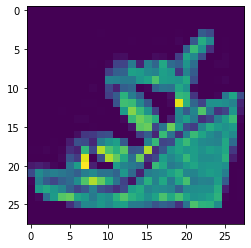

In [6]:
plt.imshow(X_val[1].reshape(28,28));

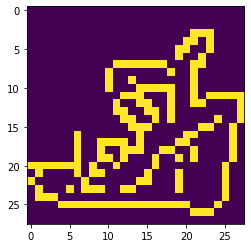

In [7]:
edge = preprocessing(X_val[1].reshape(28,28))
#print(edge.shape)
plt.imshow(edge);
#np.unique(edge.flatten())

In [8]:
np.argmax(y_train[0], axis=0),np.argmax(y_train[1], axis=0)

(7, 9)

In [9]:
np.argmax((y_train), axis=0)

array([ 2,  3,  6, 11, 13,  4,  5,  0,  8,  1], dtype=int64)

In [10]:
temp_img1 = X_train[0]
temp_y1 = y_train[0]

temp_img2 = X_train[1]
temp_y2 = y_train[1]

In [11]:
temp_img2.shape

(784,)

In [12]:
prev_lab = []
for i in range(y_train.shape[0]):
    prev_lab.append(np.argmax(y_train[i], axis=0))    

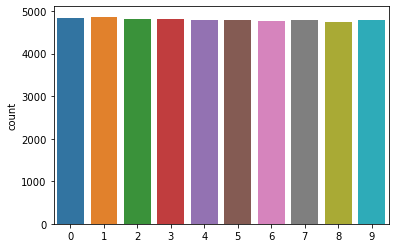

In [13]:
sns.countplot(prev_lab);

0 class imbalanced
1 class imbalanced

0: T-shirt/top
1: Trouser

In [14]:
c = 0

for i in range(X_train.shape[0]):
    if np.argmax(y_train[i], axis=0) == 0:
        X_train[i] = temp_img1
        y_train[i] = temp_y1
        c = c + 1
        #print(str(c) + " " + str(i))
        if (c == 3300):
            print("done")
            break
        else:
            pass

c = 0

for i in range(X_train.shape[0]):
    if np.argmax(y_train[i], axis=0) == 1:
        X_train[i] = temp_img2
        y_train[i] = temp_y2
        c = c + 1
        #print(str(c) + " " + str(i))
        if (c == 3300):
            print("done")

            break
        else:
            pass

done
done


In [15]:
pre_lab = []
for i in range(y_train.shape[0]):
    pre_lab.append(np.argmax(y_train[i], axis=0))  

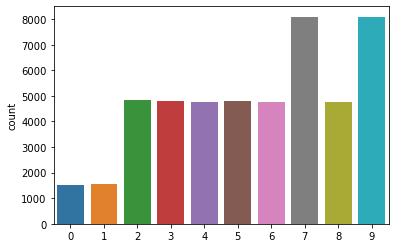

In [16]:
sns.countplot(pre_lab);

In [17]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

temp = X_test.copy()
blurry_x = temp[:100]
not_blurry_x = temp[:100]

for i in range(int(0.4*X_train.shape[0])):
    img = X_train[i]
    img = img.astype('float32')
    img = np.reshape(img,(28,28))
    img = cv2.GaussianBlur(img,(5,5),1)
    img = img.reshape(28,28,1)
    X_train[i] = img

for i in range(int(0.4*X_val.shape[0])):
    img = X_val[i]
    img = np.reshape(img,(28,28))
    img = img.astype('float32')
    img = cv2.GaussianBlur(img,(5,5),1)
    img = img.reshape(28,28,1)
    X_val[i] = img
    
for i in range(X_train.shape[0]):
    img = preprocessing(X_train[i].reshape(28,28))
    img = img.reshape(28,28,1)
    X_train[i] = img

for i in range(X_val.shape[0]):
    img = preprocessing(X_val[i].reshape(28,28))
    img = img.reshape(28,28,1)
    X_val[i] = img

for i in range(X_test.shape[0]):
    img = preprocessing(X_test[i].reshape(28,28))
    img = img.reshape(28,28,1)
    X_test[i] = img


test_y = y_test[:100]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_test /= 255
X_val /= 255

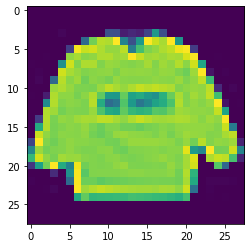

In [18]:
plt.imshow(not_blurry_x[0].reshape(28,28));

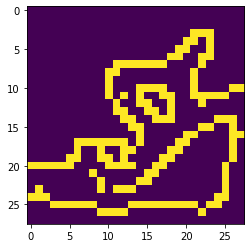

In [19]:
plt.imshow(X_val[1].reshape((28,28)));

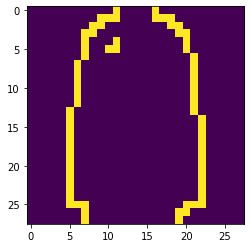

In [20]:
img = preprocessing(X_val[1000].reshape(28,28))
plt.imshow(X_val[100].reshape(28,28))

(30, 30)


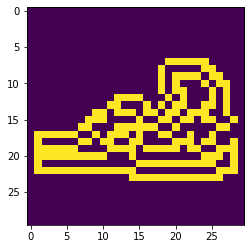

In [21]:
#edge = preprocessing(X_val[1].reshape(28,28))
img = X_val[90].reshape(28,28)

Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
#Calculate of x,y gradient
Ix = convolve(img, Kx)
Iy = convolve(img, Ky)
#Calculate normalized gradient magnitude and theta
g = np.hypot(Ix, Iy)
#G = G / G.max() * 255
theta = np.arctan2(Iy, Ix)
#return (G, theta)
#Gradient,theta = sobel_filters(img_name)
nms = non_max_suppression(g,theta)
edge,weak,strong = threshold(nms)
hyst = hysteresis(edge,weak=weak)
#hyst = cv2.resize(hyst,(28,28))
print(hyst.shape)
plt.imshow(hyst);

In [22]:



batch_size = 256
num_classes = 10
epochs = 50

#input image dimensions
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
____

In [23]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callback = LearningRateScheduler(scheduler)

output = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=2,
          verbose=1,
          validation_data=(X_val, y_val),callbacks=[early])

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
 3840/48000 [=>............................] - ETA: 3:46 - loss: 1.6346 - acc: 0.4872

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(6,3))
#history of accuracy
plt.plot(output.history['acc'])
plt.plot(output.history['val_acc'])
plt.title('classifier accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(6,3))
plt.plot(output.history['loss'])
plt.plot(output.history['val_loss'])
plt.title('classifier loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
plt.imshow(not_blurry_x[10].reshape(28,28));

In [ ]:
for i in range(blurry_x.shape[0]):
    img = blurry_x[i]
    img = img.astype('float32')
    img = np.reshape(img,(28,28))
    img = cv2.GaussianBlur(img,(5,5),1)
    img = img.reshape(28,28,1)
    blurry_x[i] = img
    
plt.imshow(blurry_x[10].reshape(28,28));

In [ ]:
for i in range(not_blurry_x.shape[0]):
    img = preprocessing(not_blurry_x[i].reshape(28,28))
    img = img.reshape(28,28,1)
    not_blurry_x[i] = img
    
plt.imshow(not_blurry_x[10].reshape(28,28));

In [ ]:
score = model.evaluate(not_blurry_x/255., test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
#plt.imshow(blurry_x[10].reshape(28,28));

In [ ]:
for i in range(blurry_x.shape[0]):
    img = preprocessing(blurry_x[i].reshape(28,28))
    img = img.reshape(28,28,1)
    blurry_x[i] = img

In [ ]:
plt.imshow(blurry_x[10].reshape(28,28));

In [ ]:
score = model.evaluate(blurry_x/255., test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
#save model
model.save(r'C:\Users\user\Desktop\model.h5')

In [ ]:
# load model
model = load_model('model.h5')

In [ ]:
# summarize model.
model.summary()

In [ ]:
score = model.evaluate(blurry_x/255., test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
#from tensorflow.keras.applications import decode_predictions